# Clustering do dataset "compscience_papers.csv" usando K-means e TF-IDF

Neste Jupyter Notebook, utiliza-se o TFIDF vectorizer e o MiniBatchKmeans do Sklearn para implementar um algoritmo de clustering simples. Depois visualiza-se esses clusters usando PCA e TSNE, assim como são mostradas as principais palavras-chave de cada cluster. 

In [12]:
import sys
# !{sys.executable} -m spacy download en
import re
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])


## Importando o dataset

Utiliza-se a biblioteca Pandas para importar o arquivo "compscience_papers.csv"

In [2]:
data = pd.read_csv("compscience_papers.csv")
data.head()

,text,label
0,Digital Image Similarity for Geo-spatial Knowl...,1
1,An Initial Experiment into Stereochemistry-Bas...,2
2,Collaborative Case-Based Recommender Systems\n...,1
3,Knowledge Engineering for CBR systems from a C...,1
4,Analyses for Elucidating Current Question Answ...,3


## Extraindo palavras-chave

Utiliza-se o TfidfVectorizer do Sklearn para a extração de palavras-chave, elas serão utilizadas para formar os clusters.

In [3]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = stop_words
)
tfidf.fit(data.text)
text = tfidf.transform(data.text)

## Encontrando a quantidade ideal de clusters

No código abaixo, calcula-se o Sum of Squared Error (SSE) para vários tamanhos de cluster, neste caso até 14, e depois procura-se o "cotovelo" onde o SSE começa a se estabilizar. 

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


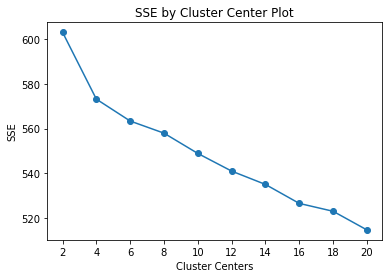

In [4]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 20)

In [5]:
clusters = MiniBatchKMeans(n_clusters=4,  batch_size=682, random_state=0).fit_predict(text)

## Visualização dos clusters

Abaixo, visualiza-se os clusters gerados pelo algoritmo K-means. Um gráfico usa o PCA, que é melhor na captura da estrutura global dos dados. O outro usa TSNE, que é melhor em capturar relações entre vizinhos.

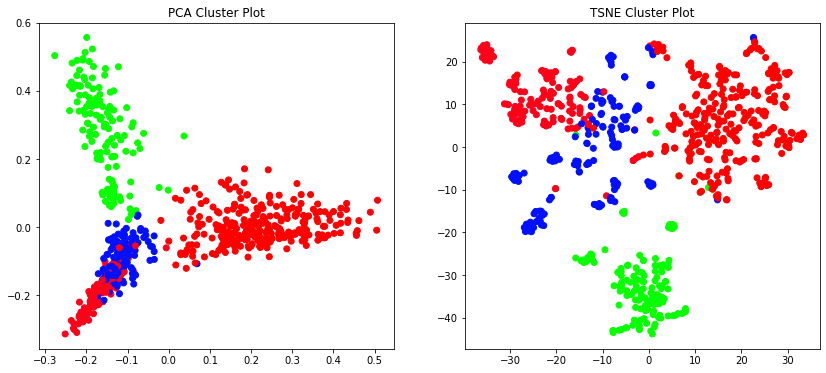

In [6]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=682, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=682, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)

In [18]:
import plotly.express as px

n_topics = 4
#mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

# Format

max_label = max(clusters)
max_items = np.random.choice(range(text.shape[0]), size=682, replace=False)
    
pca = PCA(n_components=2).fit_transform(text[max_items,:].todense())
tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(text[max_items,:].todense()))
    
    
idx = np.random.choice(range(pca.shape[0]), size=682, replace=False)
label_subset = clusters[max_items]
label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]

df = data["text"]
fig = px.scatter(df, x=tsne[idx, 0], y=tsne[idx, 1], )
fig.show()

## Principais palavras-chave

Por fim, percorre-se os clusters e são impressas as principais palavras-chave com base na pontuação do TFIDF para ver se é possível identificar alguma tendência. Faz-se isso calculando um valor médio entre todas as dimensões no Pandas, agrupadas pelo rótulo do cluster.

In [9]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
design,artificial,knowledge,intelligence,proceedings,cbr,learning,reasoning,based,case

Cluster 1
proceedings,raedt,machine,pages,ilp,muggleton,programming,inductive,learning,logic

Cluster 2
semantic,acm,sigir,conference,language,proceedings,pages,text,retrieval,information

Cluster 3
computer,virtual,display,visualization,sonification,sound,music,pp,auditory,audio
